# 기상 특성에 따른 안개 발생 진단

## 데이터 설명
- 컬럼

    - `Year` : 년도
    - `Month` : 월
    - `Day` : 일
    - `Time` : 시간 (0 ~ 23)
    - `Minute` : 분 (10분 단위)
    - `STN_ID` : 지점 번호
    - `WS10(deg)` : 10분 평균 풍향, 단위: deg
    - `WS10(m/s)` : 10분 평균 풍속, 단위: m/s
    - `TA` : 1분 평균 기온 10분 주기, 단위: C
    - `RE` : 강수 유무 (0:무강수, 1:강수)
    - `HM` : 1분 평균 상대 습도 10분 주기, 단위: %
    - `sun10` : 1분 일사량 10분단위 합계, 단위: MJ
    - `TS` : 1분 평균 지면온도 10분 주기, 단위: C
    - `VIS1` : 1분 평균 시정 10분 주기, 단위: C (VIS1 변수는 시정 구간을 알 수 있는 변수로 검증 데이터에서는 제외)
    - `class` : 시정 구간

- 시정 계급 기준 (비고: 안개의 기준)

    - `1` : 0 < 시정 < 200
    - `2` : 200 <= 시정 < 500
    - `3` : 500 <= 시정 < 1000
    - `4` : 1000 <= 시정


## 데이터 불러오기

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# 데이터셋 경로 지정
train_path = "../fog_data/fog_train.csv"
test_path = "../fog_data/fog_test.csv"

In [4]:
# 데이터셋 불러오기
train_df = pd.read_csv(train_path, index_col=0)
test_df = pd.read_csv(test_path, index_col=0)

In [5]:
train_df.head()

,fog_train.year,fog_train.month,fog_train.day,fog_train.time,fog_train.minute,fog_train.stn_id,fog_train.ws10_deg,fog_train.ws10_ms,fog_train.ta,fog_train.re,fog_train.hm,fog_train.sun10,fog_train.ts,fog_train.vis1,fog_train.class
1,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
2,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
3,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4
4,I,1,1,0,40,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000,4
5,I,1,1,0,50,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000,4


In [6]:
test_df.head()

,fog_test.year,fog_test.month,fog_test.day,fog_test.time,fog_test.minute,fog_test.stn_id,fog_test.ws10_deg,fog_test.ws10_ms,fog_test.ta,fog_test.re,fog_test.hm,fog_test.sun10,fog_test.ts,fog_test.class
1,L,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
2,L,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
3,L,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN
4,L,1,1,0,30,AI,323.6,0.7,-2.6,0.0,88.7,0.0,-1.6,NaN
5,L,1,1,0,40,AI,208.4,0.2,-2.6,0.0,89.0,0.0,-1.6,NaN


In [7]:
train_df.shape, test_df.shape

((3156459, 15), (262800, 14))

## 데이터 확인

In [8]:
train_df.describe(include="all")

,fog_train.year,fog_train.month,fog_train.day,fog_train.time,fog_train.minute,fog_train.stn_id,fog_train.ws10_deg,fog_train.ws10_ms,fog_train.ta,fog_train.re,fog_train.hm,fog_train.sun10,fog_train.ts,fog_train.vis1,fog_train.class
count,3156459,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3156459,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06
unique,3,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,I,NaN,NaN,NaN,NaN,AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1054060,NaN,NaN,NaN,NaN,157823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,6.521931e+00,1.573276e+01,1.150007e+01,2.500016e+01,NaN,1.852152e+02,1.999417e+00,1.328812e+01,-4.298995e-01,6.667729e+01,-1.288869e+00,1.282955e+01,1.963548e+04,3.246275e+00
std,NaN,3.448969e+00,8.801320e+00,6.922149e+00,1.707819e+01,NaN,1.072184e+02,4.721616e+00,1.100537e+01,6.929268e+00,2.173623e+01,1.171355e+01,2.257327e+01,1.206407e+04,8.668957e+00
min,NaN,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,NaN,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.900000e+01,-9.900000e+01
25%,NaN,4.000000e+00,8.000000e+00,6.000000e+00,1.000000e+01,NaN,8.470000e+01,9.000000e-01,5.500000e+00,0.000000e+00,5.130000e+01,0.000000e+00,5.100000e+00,1.229700e+04,4.000000e+00
50%,NaN,7.000000e+00,1.600000e+01,1.200000e+01,3.000000e+01,NaN,2.094000e+02,1.800000e+00,1.430000e+01,0.000000e+00,6.870000e+01,0.000000e+00,1.570000e+01,2.000000e+04,4.000000e+00
75%,NaN,1.000000e+01,2.300000e+01,1.800000e+01,4.000000e+01,NaN,2.769000e+02,3.000000e+00,2.200000e+01,0.000000e+00,8.470000e+01,1.600000e-01,2.430000e+01,2.000000e+04,4.000000e+00


In [9]:
test_df.describe(include="all")

,fog_test.year,fog_test.month,fog_test.day,fog_test.time,fog_test.minute,fog_test.stn_id,fog_test.ws10_deg,fog_test.ws10_ms,fog_test.ta,fog_test.re,fog_test.hm,fog_test.sun10,fog_test.ts,fog_test.class
count,262800,262800.000000,262800.000000,262800.0000,262800.000000,262800,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,2694.0
unique,1,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,L,NaN,NaN,NaN,NaN,AI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,262800,NaN,NaN,NaN,NaN,52560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,6.526027,15.720548,11.5000,25.000000,NaN,196.658506,2.209763,13.762124,-1.659824,66.988850,0.057753,12.861969,-99.0
std,NaN,3.447858,8.796264,6.9222,17.078284,NaN,102.654641,3.479083,10.731883,12.973129,21.925011,2.097243,22.992859,0.0
min,NaN,1.000000,1.000000,0.0000,0.000000,NaN,-99.900000,-99.900000,-99.900000,-99.900000,-99.900000,-99.900000,-99.900000,-99.0
25%,NaN,4.000000,8.000000,5.7500,10.000000,NaN,108.900000,1.000000,5.600000,0.000000,51.100000,0.000000,4.600000,-99.0
50%,NaN,7.000000,16.000000,11.5000,25.000000,NaN,220.400000,2.000000,15.100000,0.000000,69.300000,0.000000,15.900000,-99.0
75%,NaN,10.000000,23.000000,17.2500,40.000000,NaN,287.100000,3.100000,22.600000,0.000000,86.100000,0.170000,24.500000,-99.0


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3156459 entries, 1 to 3156459
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   fog_train.year      object 
 1   fog_train.month     int64  
 2   fog_train.day       int64  
 3   fog_train.time      int64  
 4   fog_train.minute    int64  
 5   fog_train.stn_id    object 
 6   fog_train.ws10_deg  float64
 7   fog_train.ws10_ms   float64
 8   fog_train.ta        float64
 9   fog_train.re        float64
 10  fog_train.hm        float64
 11  fog_train.sun10     float64
 12  fog_train.ts        float64
 13  fog_train.vis1      int64  
 14  fog_train.class     int64  
dtypes: float64(7), int64(6), object(2)
memory usage: 385.3+ MB


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262800 entries, 1 to 262800
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fog_test.year      262800 non-null  object 
 1   fog_test.month     262800 non-null  int64  
 2   fog_test.day       262800 non-null  int64  
 3   fog_test.time      262800 non-null  int64  
 4   fog_test.minute    262800 non-null  int64  
 5   fog_test.stn_id    262800 non-null  object 
 6   fog_test.ws10_deg  262800 non-null  float64
 7   fog_test.ws10_ms   262800 non-null  float64
 8   fog_test.ta        262800 non-null  float64
 9   fog_test.re        262800 non-null  float64
 10  fog_test.hm        262800 non-null  float64
 11  fog_test.sun10     262800 non-null  float64
 12  fog_test.ts        262800 non-null  float64
 13  fog_test.class     2694 non-null    float64
dtypes: float64(8), int64(4), object(2)
memory usage: 30.1+ MB


In [12]:
# 결측치 확인
train_df.isnull().sum()

fog_train.year        0
fog_train.month       0
fog_train.day         0
fog_train.time        0
fog_train.minute      0
fog_train.stn_id      0
fog_train.ws10_deg    0
fog_train.ws10_ms     0
fog_train.ta          0
fog_train.re          0
fog_train.hm          0
fog_train.sun10       0
fog_train.ts          0
fog_train.vis1        0
fog_train.class       0
dtype: int64

In [13]:
test_df.isnull().sum()

fog_test.year             0
fog_test.month            0
fog_test.day              0
fog_test.time             0
fog_test.minute           0
fog_test.stn_id           0
fog_test.ws10_deg         0
fog_test.ws10_ms          0
fog_test.ta               0
fog_test.re               0
fog_test.hm               0
fog_test.sun10            0
fog_test.ts               0
fog_test.class       260106
dtype: int64

In [14]:
# 컬럼별 unique 값 확인
print('train_df["year"] :', train_df["fog_train.year"].unique())
print('test_df["year"] :', test_df["fog_test.year"].unique())

train_df["year"] : ['I' 'J' 'K']
test_df["year"] : ['L']


In [15]:
print('train_df["stn_id"] :', train_df["fog_train.stn_id"].unique())
print('test_df["stn_id"] :', test_df["fog_test.stn_id"].unique())

train_df["stn_id"] : ['AA' 'AB' 'AC' 'AD' 'AE' 'AF' 'AG' 'AH' 'BA' 'BB' 'BC' 'BD' 'CA' 'CB'
 'DA' 'DB' 'DC' 'EA' 'EB' 'EC']
test_df["stn_id"] : ['AI' 'BE' 'CC' 'DD' 'ED']


In [16]:
print('train_df["class"] :', train_df["fog_train.class"].unique())
print('test_df["class"] :', test_df["fog_test.class"].unique())

train_df["class"] : [  4   1   3   2 -99]
test_df["class"] : [ nan -99.]


In [17]:
# class 원래 범위 1 ~ 4, 그러나 -99가 존재
# -99가 뭔지 확인해본다
train_df[train_df["fog_train.class"]==-99].head()

,fog_train.year,fog_train.month,fog_train.day,fog_train.time,fog_train.minute,fog_train.stn_id,fog_train.ws10_deg,fog_train.ws10_ms,fog_train.ta,fog_train.re,fog_train.hm,fog_train.sun10,fog_train.ts,fog_train.vis1,fog_train.class
7646,I,2,23,2,20,AA,272.0,1.3,-0.9,0.0,61.1,0.00,-1.0,-99,-99
7781,I,2,24,0,50,AA,140.7,1.2,2.1,0.0,59.5,0.00,0.8,-99,-99
16054,I,4,21,11,40,AA,271.7,7.0,9.2,0.0,42.8,0.32,16.7,-99,-99
16055,I,4,21,11,50,AA,276.4,6.0,9.3,0.0,43.4,0.26,19.0,-99,-99
16056,I,4,21,12,0,AA,268.4,5.9,9.5,0.0,41.7,0.48,21.1,-99,-99


In [18]:
test_df[test_df["fog_test.class"]==-99].head()

,fog_test.year,fog_test.month,fog_test.day,fog_test.time,fog_test.minute,fog_test.stn_id,fog_test.ws10_deg,fog_test.ws10_ms,fog_test.ta,fog_test.re,fog_test.hm,fog_test.sun10,fog_test.ts,fog_test.class
367,L,1,3,13,0,AI,141.9,0.8,-1.9,0.0,40.5,0.31,-1.6,-99.0
465,L,1,4,5,20,AI,151.9,0.3,-13.2,0.0,81.9,0.00,-99.9,-99.0
2164,L,1,16,0,30,AI,208.6,1.6,-0.6,0.0,84.1,0.00,0.0,-99.0
2198,L,1,16,6,10,AI,209.8,2.6,-3.0,0.0,78.4,0.00,-0.1,-99.0
2527,L,1,18,13,0,AI,-99.9,-99.9,-99.9,-99.9,-99.9,0.32,-99.9,-99.0


In [19]:
# class = -99인 데이터의 year, month, stn_id, vis1 컬럼 확인
# train_df
print(sorted(train_df[train_df["fog_train.class"]==-99]["fog_train.year"].unique()))
print(sorted(train_df[train_df["fog_train.class"]==-99]["fog_train.month"].unique()))
print(sorted(train_df[train_df["fog_train.class"]==-99]["fog_train.stn_id"].unique()))
print(sorted(train_df[train_df["fog_train.class"]==-99]["fog_train.vis1"].unique()))

['I', 'J', 'K']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
['AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'BA', 'BB', 'BC', 'BD', 'CA', 'CB', 'DA', 'DB', 'DC', 'EA', 'EB', 'EC']
[-99]


In [20]:
# class = -99인 데이터의 year, month, stn_id, vis1 컬럼 확인
# test_df
print(sorted(test_df[test_df["fog_test.class"]==-99]["fog_test.year"].unique()))
print(sorted(test_df[test_df["fog_test.class"]==-99]["fog_test.month"].unique()))
print(sorted(test_df[test_df["fog_test.class"]==-99]["fog_test.stn_id"].unique()))
# print(sorted(test_df[test_df["class"]==-99]["vis1"].unique()))

['L']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
['AI', 'BE', 'CC', 'DD', 'ED']


In [21]:
train_df

,fog_train.year,fog_train.month,fog_train.day,fog_train.time,fog_train.minute,fog_train.stn_id,fog_train.ws10_deg,fog_train.ws10_ms,fog_train.ta,fog_train.re,fog_train.hm,fog_train.sun10,fog_train.ts,fog_train.vis1,fog_train.class
1,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
2,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
3,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4
4,I,1,1,0,40,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000,4
5,I,1,1,0,50,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,K,12,31,23,10,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000,4
3156456,K,12,31,23,20,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000,4
3156457,K,12,31,23,30,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000,4
3156458,K,12,31,23,40,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000,4


### class = -99인 데이터 비율

In [22]:
def check_rate(train_df, test_df):
    # class = -99인 것 size
    
    # train_df
    class_99_tr = train_df[train_df["fog_train.class"]==-99].size
    total_cnt_tr = train_df.size
    class_99_pct_tr = round((class_99_tr/total_cnt_tr)*100, 1)

    # test_df
    class_99_test = test_df[test_df["fog_test.class"]==-99].size
    total_cnt_test = test_df.size
    class_99_pct_test = round((class_99_test/total_cnt_test)*100, 1)
    
    class_99_df = pd.DataFrame({"train_total" :[total_cnt_tr], "test_total": [total_cnt_test], "train_pct (%)":[class_99_pct_tr], "test_pct (%)":[class_99_pct_test]}, index=["class_99"])
    return class_99_df

In [23]:
check_rate(train_df, test_df)

,train_total,test_total,train_pct (%),test_pct (%)
class_99,47346885,3679200,0.7,1.0


## Preprocessing & EDA
- `stn_id` : A, B, C, D, E로 바꾸자
- `class` : -99 -> 결측치

In [24]:
# train_df, test_df 컬럼들 앞에 있는 fog_train, fog_test. <- 제거
train_df.columns = train_df.columns.str.replace("fog_train.", "")
test_df.columns = test_df.columns.str.replace("fog_test.", "")

In [25]:
train_df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
1,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
2,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
3,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4
4,I,1,1,0,40,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000,4
5,I,1,1,0,50,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,K,12,31,23,10,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000,4
3156456,K,12,31,23,20,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000,4
3156457,K,12,31,23,30,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000,4
3156458,K,12,31,23,40,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000,4


In [26]:
# "year", "day","time","minute", "vis1","class" 컬럼 제외하고 조회
coef_columns_tr=train_df.columns.difference(["year", "day","time","minute", "vis1","class"])
len(coef_columns_tr)

9

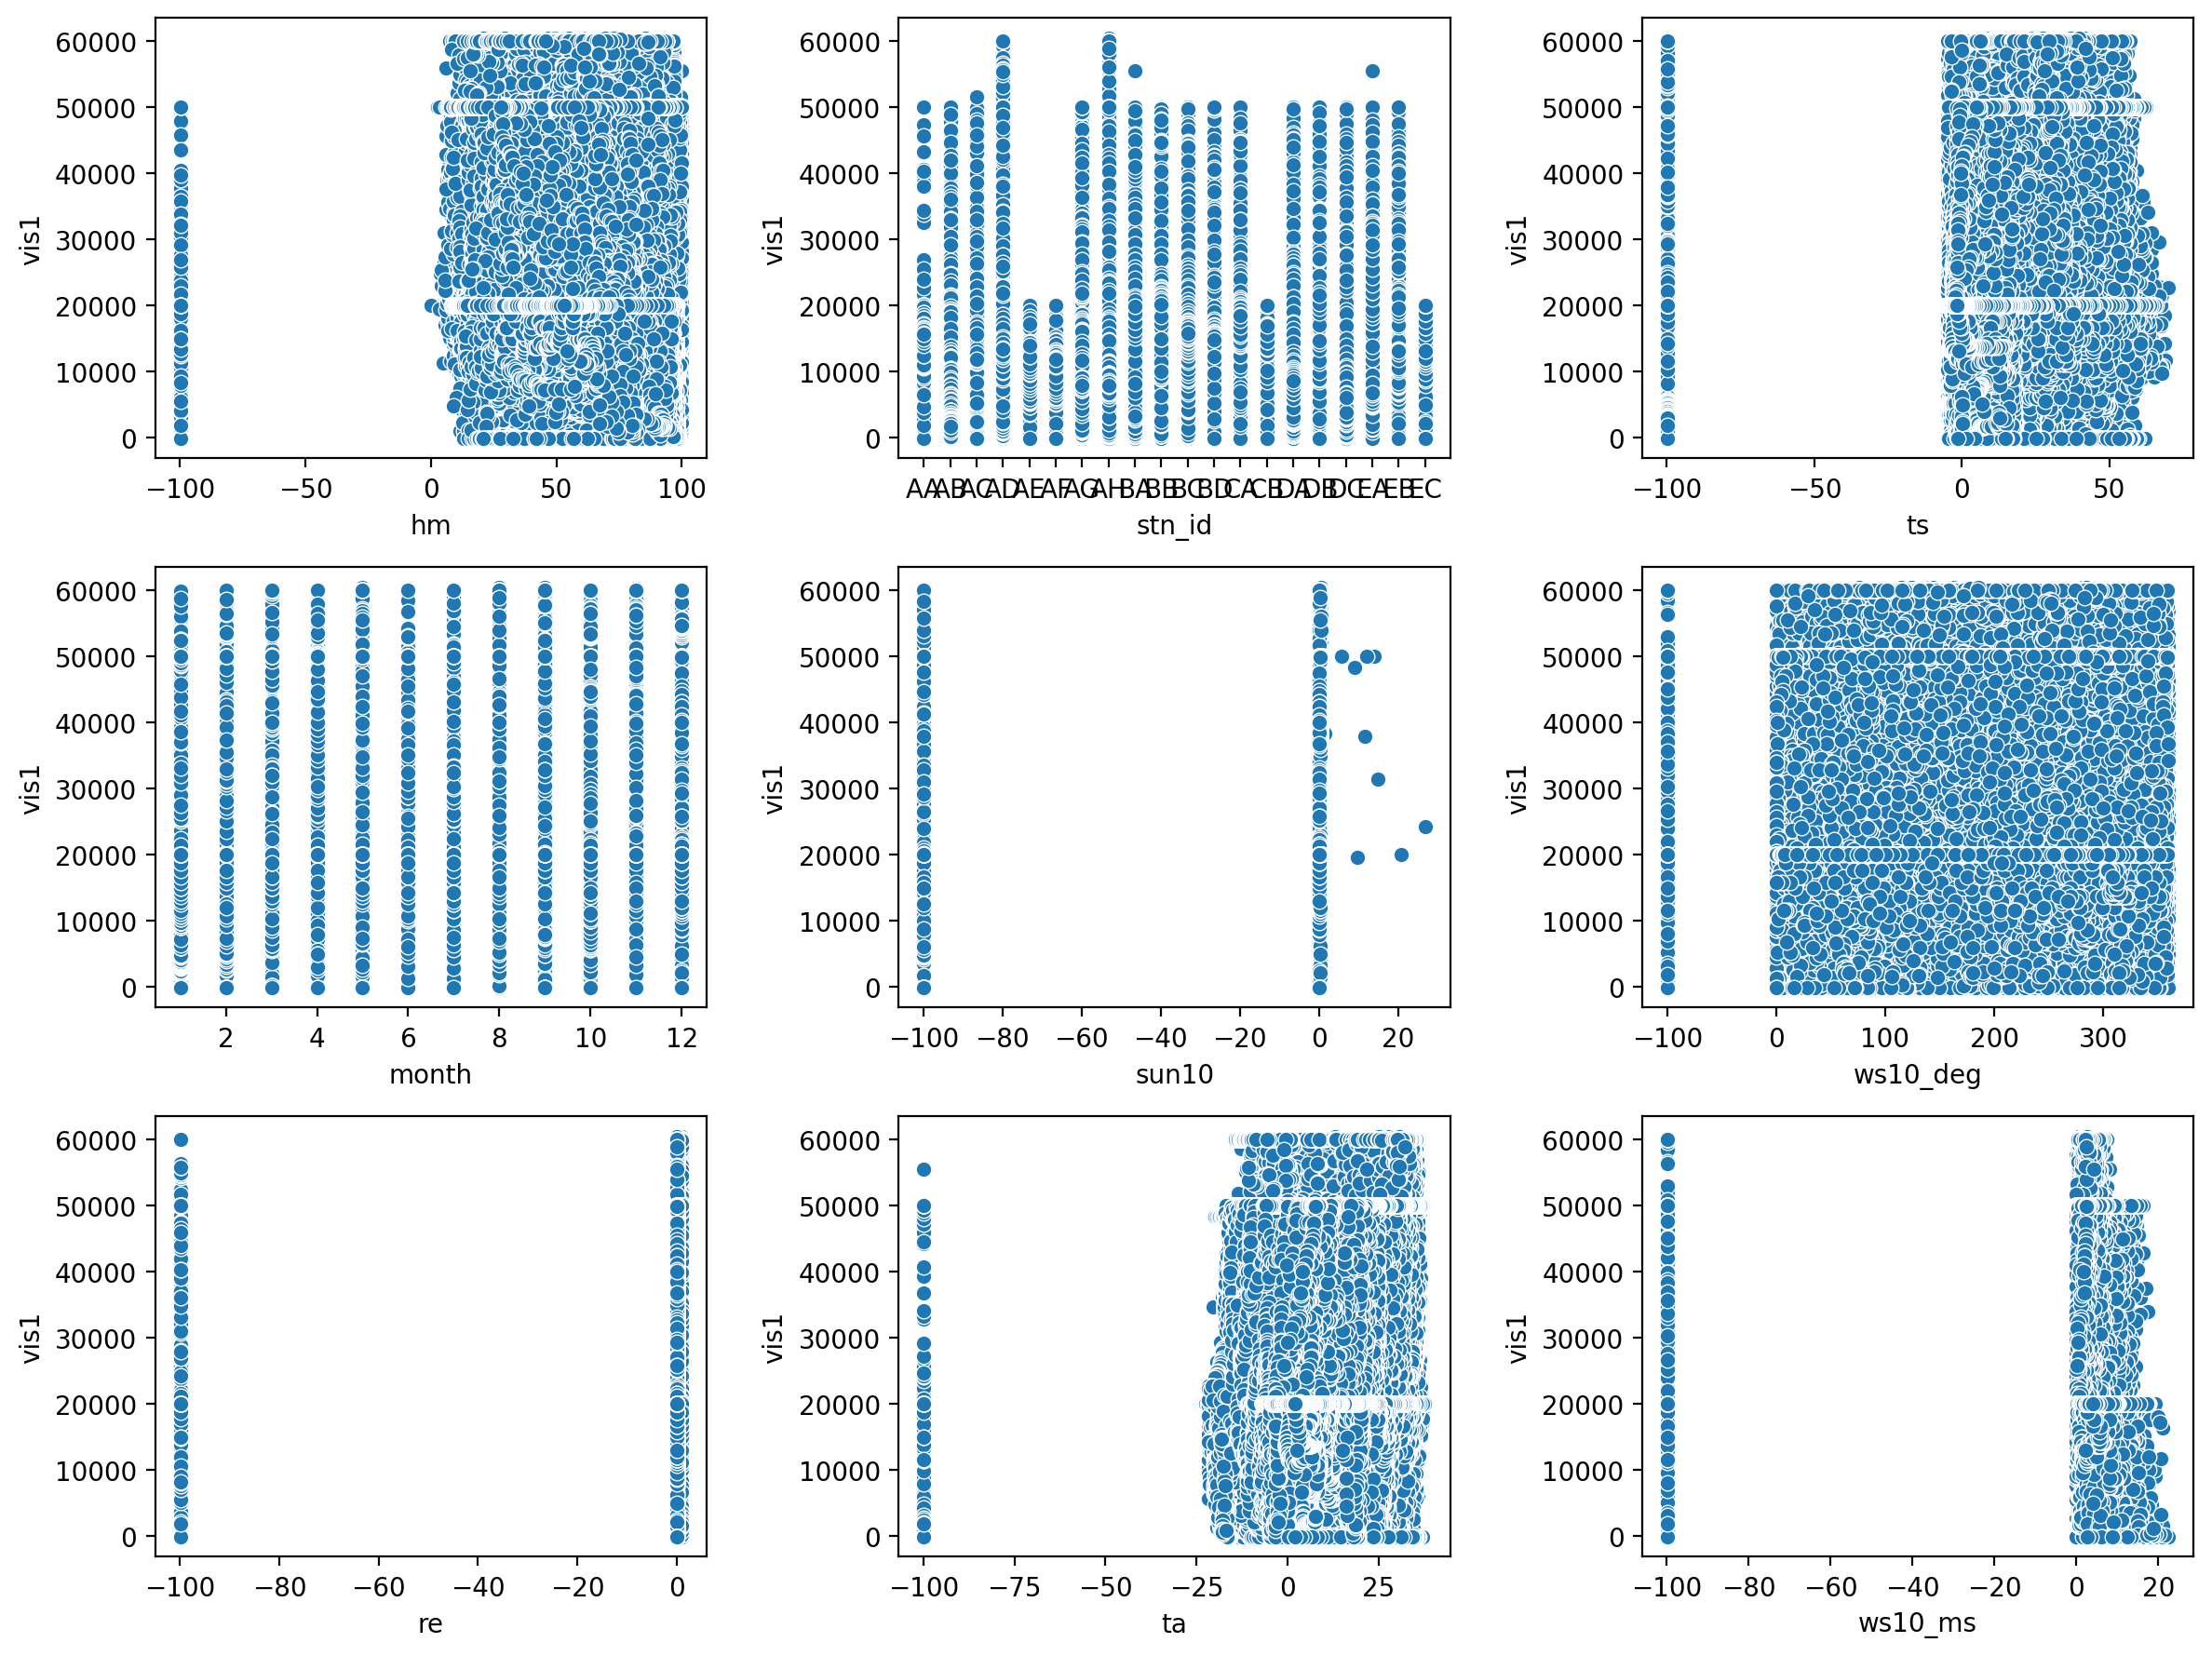

In [27]:
# train_df 시각화 (scatterplot)
# subplot 생성
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 9))

# flatten()을 통해 axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()

for col, ax in zip(coef_columns_tr, axes): 
    sns.scatterplot(data=train_df, x=col, y='vis1', ax=ax)

fig.tight_layout()
plt.show()    

In [28]:
# train_df vis1 (1분 평균 시정) 확인
train_df['vis1'].max()

60525

In [29]:
# train_df 관측소별 vis 확인 - 최대값
train_df.groupby(["stn_id"])["vis1"].max()

stn_id
AA    50000
AB    50100
AC    51639
AD    60000
AE    20000
AF    20000
AG    50000
AH    60525
BA    55537
BB    50000
BC    50000
BD    50000
CA    50000
CB    20000
DA    50000
DB    50000
DC    50100
EA    55537
EB    50000
EC    20000
Name: vis1, dtype: int64

In [30]:
# train_df 관측소별 vis 확인 - 최소값 (결측치인 -99 나옴)
train_df.groupby(["stn_id"])["vis1"].min()

stn_id
AA   -99
AB   -99
AC   -99
AD   -99
AE   -99
AF   -99
AG   -99
AH   -99
BA   -99
BB   -99
BC   -99
BD   -99
CA   -99
CB   -99
DA   -99
DB   -99
DC   -99
EA   -99
EB   -99
EC   -99
Name: vis1, dtype: int64

In [31]:
# train_df 관측소별 vis 확인 (-99인 결측치 제외)
train_df[train_df.vis1 >=0].groupby(["stn_id"])["vis1"].min()

stn_id
AA      1
AB     20
AC     88
AD      4
AE     30
AF     87
AG     11
AH     10
BA     26
BB     62
BC     80
BD     17
CA     17
CB    178
DA      8
DB     10
DC     18
EA     10
EB     52
EC      4
Name: vis1, dtype: int64

In [32]:
# train_df["class"]의 결측치 비율 확인
train_df["class"].value_counts(normalize=True)

class
 4     0.982686
-99    0.007133
 3     0.003859
 2     0.003830
 1     0.002492
Name: proportion, dtype: float64

In [33]:
# train_df 수치형 변수만 확인
num_cols = train_df.describe().columns
train_df[num_cols]

,month,day,time,minute,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
1,1,1,0,10,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
2,1,1,0,20,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
3,1,1,0,30,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4
4,1,1,0,40,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000,4
5,1,1,0,50,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,12,31,23,10,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000,4
3156456,12,31,23,20,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000,4
3156457,12,31,23,30,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000,4
3156458,12,31,23,40,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000,4


In [34]:
# train_df 문자형 변수 확인
train_df.select_dtypes(include="object").columns

Index(['year', 'stn_id'], dtype='object')

In [35]:
train_df[train_df.vis1<20000]

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
10,I,1,1,1,40,AA,29.8,0.1,-5.7,0.0,41.4,0.0,-2.5,18510,4
14,I,1,1,2,20,AA,38.5,0.1,-5.5,0.0,43.6,0.0,-2.6,18971,4
19,I,1,1,3,10,AA,40.8,0.0,-5.6,0.0,46.3,0.0,-2.6,19165,4
34,I,1,1,5,40,AA,-99.9,-99.9,-5.0,0.0,56.5,0.0,-2.1,18219,4
35,I,1,1,5,50,AA,-99.9,-99.9,-4.9,0.0,57.3,0.0,-2.1,17846,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156308,K,12,30,22,40,EC,289.8,4.2,2.3,0.0,56.6,0.0,-0.9,17647,4
3156309,K,12,30,22,50,EC,271.7,2.7,2.2,0.0,56.9,0.0,-1.2,18750,4
3156310,K,12,30,23,0,EC,275.7,2.7,2.1,0.0,57.0,0.0,-1.5,-99,-99
3156311,K,12,30,23,10,EC,283.6,2.5,1.9,0.0,57.2,0.0,-1.5,18750,4


In [36]:
# train 전체 데이터셋에서 vis1 컬럼 값이 20,000 이하인 것의 비율
1427376 / train_df.shape[0]

0.4522079963655476

### 컬럼 수정 및 제거, 결측치 제거
- `stn_id` 수정 : A, B, C, D, E로 수정

- `class` = -99인 데이터 (결측치) 제거
- `year`, `month`, `day`, `time`, `minute`, `class` 컬럼 drop

In [37]:
def stn_id_class_modify(train_df, test_df):

    # stn_id 수정 : A, B, C, D, E로 수정
    train_df["stn_id"] = train_df["stn_id"].apply(lambda x: x[0])
    test_df["stn_id"] = test_df["stn_id"].apply(lambda x: x[0])

    # class = -99인 데이터 (결측치) 제거

    # class=-99인 데이터 index
    class_99_idx_tr = train_df.loc[train_df["class"]==-99].index
    class_99_idx_test = test_df.loc[test_df["class"]==-99].index

    # index 기반으로 class=-99인 데이터 삭제
    train_df.drop(index=class_99_idx_tr, inplace=True)
    test_df.drop(index=class_99_idx_test, inplace=True)

    # year, month, day, time, minute, class 컬럼 drop
    train_df.drop(columns=["year", "month", "day", "time", "minute", "class"], inplace=True)
    test_df.drop(columns=["year", "month", "day", "time", "minute", "class"], inplace=True)

    return train_df, test_df

In [38]:
train_df, test_df = stn_id_class_modify(train_df, test_df)

In [39]:
train_df.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1
1,A,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000
2,A,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000
3,A,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000


In [40]:
test_df.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts
1,A,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6
2,A,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6
3,A,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7


## 모델링

### 데이터 분리

#### Train, Validation 데이터 분리

In [41]:
# Target 컬럼 : vis1
target = "vis1"

# train_df의 컬럼들 중 target (vis1) 제외한 컬럼들 features에 선언
features = train_df.drop(columns=[target]).columns

In [42]:
# test 데이터에 target 컬럼 (vis1) 만들어 빈 데이터 넣어준다
test_df["vis1"] = pd.Series()

In [43]:
# validation 데이터셋 생성
train, val = train_test_split(train_df, train_size=0.75, random_state=42)

In [44]:
# # train, validation, test 데이터 나눠준다
# X_train = train[features]
# y_train = train[target]

# # validation 데이터 나눠준다
# X_val = val[features]
# y_val = val[target]

# # test 데이터 나눠준다 (class 제거)
# X_test = test_df[features]
# y_test = test_df[target]

# X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

In [45]:
# train, validation 데이터셋 shape 확인
train.shape, val.shape

((2350457, 9), (783486, 9))

#### `vis1` > 20,000인 데이터 20,000으로 치환

In [46]:
def replace_vis1(train):
    # train 데이터셋 vis1 > 20000인 데이터를 20000으로 치환
    train["vis1"] = train["vis1"].apply(lambda x: 20000 if x > 20000 else x)
    return train

In [47]:
train = replace_vis1(train)

In [48]:
train.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1
1659092,B,91.2,2.9,23.8,0.0,79.7,0.51,34.8,20000
2132398,A,199.0,3.1,26.2,0.0,82.0,0.14,29.2,20000
2012143,E,142.7,0.3,8.0,0.0,88.4,0.18,9.6,19764


#### 인코딩

In [61]:
# stn_id를 각각 1 ~ 5로 정한 딕셔너리 생성
stn_id_map = {"A" : 1,
              "B" : 2,
              "C" : 3,
              "D" : 4,
              "E" : 5}

In [64]:
# stn_id_map을 바탕으로 stn_id 컬럼 mapping
train["stn_id"] = train["stn_id"].map(stn_id_map)
val["stn_id"] = val["stn_id"].map(stn_id_map)
test_df["stn_id"] = test_df["stn_id"].map(stn_id_map)

In [65]:
train.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1
1659092,2,91.2,2.9,23.8,0.0,79.7,0.51,34.8,20000
2132398,1,199.0,3.1,26.2,0.0,82.0,0.14,29.2,20000
2012143,5,142.7,0.3,8.0,0.0,88.4,0.18,9.6,19764


In [66]:
val.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1
1209393,1,293.2,2.1,13.7,0.0,44.4,0.04,9.6,19930
1808139,4,248.8,4.0,14.5,0.0,61.3,0.34,22.7,2205
1700192,3,247.0,2.9,8.8,0.0,42.1,0.00,5.9,12400


In [67]:
test_df.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1
1,1,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
2,1,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
3,1,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN


#### X, y 데이터 분리

In [69]:
# train, validation, test 데이터 나눠준다
X_train = train[features]
y_train = train[target]

# validation 데이터 나눠준다
X_val = val[features]
y_val = val[target]

# test 데이터 나눠준다 (class 제거)
X_test = test_df[features]

In [70]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((2350457, 8), (2350457,), (783486, 8), (783486,), (260106, 8))

### 회귀모델 평가 지표  
- `RMSLE`
    - MSE에 루트를 씌운 RMSE의 각 인자에 로그를 취해준 값
        - 로그 변환을 통해 이상치에 대한 영향을 줄이고, 모델이 이상치에 대해 과도하게 페널티를 받지 않게 한다
        - 과소평가된 항목에 큰 패널티를 부여한다
        - 상대적 ERROR 측정
        - 값의 범위가 넓은 데이터에서 이상치에 대해 변화의 폭이 크지 않다
    - 정규 분포를 따르지 않고 불균형한 모형일 때 사용되는 방법

- `R2 Score` (결정 계수)
    - 종속 변수의 총 변동 중 모델이 설명하는 변동의 비율
    - 0 ~ 1 사이의 값을 가지며, 높을 수록 모델이 데이터를 잘 설명한다는 뜻


- References
    - https://shinminyong.tistory.com/32
    - https://wikidocs.net/219419
    - https://www.inflearn.com/questions/992421/rmsle%EC%9D%98-%EC%82%AC%EC%9A%A9%EC%97%90-%EA%B4%80%ED%95%9C-%EC%A7%88%EB%AC%B8%EC%9E%85%EB%8B%88%EB%8B%A4

In [68]:
def get_rmsle(y_actual, y_pred):
    # sklearn의 mean_square_log_error 함수는 y_pred 값 중 하나라도 0 미만인 경우 에러 발생
    # y_pred + 1 만들어 0보다 크게 만들어 준다 (음수가 되지 않게 방지)
    # 이후 optuna에 적용하여 RMSLE를 기준으로 하이퍼파라미터 튜닝
    
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()                 
    return np.sqrt(mean_error)   

### Baseline 모델 생성

In [71]:
# 의사결정나무 모델로 Baseline 모델 생성
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [72]:
def baseline_model(model_name, model):
    baseline_results = []

    print(f"\n====== Baseline Model : {model_name} ======")
    
    # 모델 생성 및 훈련
    # model.fit(X_train, y_train)

    # Baseline 모델로 train, validation, test 데이터셋 예측
    y_train_pred_lr = model.predict(X_train)
    y_val_pred_lr = model.predict(X_val)

    # Baseline 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
    base_meanAbErr = metrics.mean_absolute_error(y_val, y_val_pred_lr)
    base_meanSqErr = metrics.mean_squared_error(y_val, y_val_pred_lr)
    base_rootMeanSqErr = metrics.mean_squared_error(y_val, y_val_pred_lr, squared=False)
    base_rootMeanSqLogErr = get_rmsle(y_val, y_val_pred_lr)


    # 결과를 리스트에 저장
    baseline_results.append({"Model" : model_name,
                             "MAE" : '{:.2f}'.format(base_meanAbErr),
                             "MSE" : '{:.2f}'.format(base_meanSqErr),
                             "RMSE" : '{:.2f}'.format(base_rootMeanSqErr),
                             "RMSLE" : '{:.2f}'.format(base_rootMeanSqLogErr),
                             "R2 Score" : '{:.2f}'.format(model.score(X_val, y_val))})
    
    # 결과 리스트를 DataFrame으로 변환
    baseline_df = pd.DataFrame(baseline_results)
    
    return baseline_df

In [74]:
baseline_model("Decision Tree", dt)


====== Baseline Model : Decision Tree ======


,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,Decision Tree,6779.32,135649879.04,11646.88,0.69,0.06


### 머신러닝 모델링

#### 하이퍼 파라미터 튜닝 전 모델 생성

In [75]:
# model_list = ["lr_model", "dt_model", "rf_model", "cat_model", "lgbm_model", "xgb_model"]

lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
cat_model = CatBoostRegressor(random_state=42)
lgbm_model = LGBMRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

models = [
    # ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    # ("Random Forest", RandomForestRegressor(random_state=42)),
    ("CatBoost", CatBoostRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42))
]

In [76]:
def model_comparison(models, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        # 트리 기반 모델들은 각 변수의 information gain을 기반으로 판단하기 때문에 굳이 스케일링 해줄 필요가 없다

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
        meanAbErr = metrics.mean_absolute_error(y_val, y_val_pred)
        meanSqErr = metrics.mean_squared_error(y_val, y_val_pred)
        rootMeanSqErr = metrics.mean_squared_error(y_val, y_val_pred, squared=False)
        rootMeanSqLogErr = get_rmsle(y_val, y_val_pred)

        # 결과를 리스트에 저장
        models_results.append({"Model" : model_name,
                                "MAE" : '{:.2f}'.format(meanAbErr),
                                "MSE" : '{:.2f}'.format(meanSqErr),
                                "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                "RMSLE" : '{:.2f}'.format(rootMeanSqLogErr),
                                "R2 Score" : '{:.2f}'.format(model.score(X_val, y_val))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models {when} Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["RMSLE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)

In [77]:
model_comparison(models)

Learning rate set to 0.139579
0:	learn: 5482.3229772	total: 282ms	remaining: 4m 41s
1:	learn: 5303.8720140	total: 429ms	remaining: 3m 33s
2:	learn: 5166.9148740	total: 570ms	remaining: 3m 9s
3:	learn: 5058.4660892	total: 719ms	remaining: 2m 59s
4:	learn: 4974.6566477	total: 870ms	remaining: 2m 53s
5:	learn: 4908.2458361	total: 1.02s	remaining: 2m 49s
6:	learn: 4856.7476137	total: 1.16s	remaining: 2m 44s
7:	learn: 4816.9317192	total: 1.3s	remaining: 2m 41s
8:	learn: 4784.7474641	total: 1.46s	remaining: 2m 41s
9:	learn: 4757.0833611	total: 1.61s	remaining: 2m 39s
10:	learn: 4734.4548555	total: 1.77s	remaining: 2m 39s
11:	learn: 4716.5868176	total: 1.93s	remaining: 2m 38s
12:	learn: 4701.4173884	total: 2.07s	remaining: 2m 37s
13:	learn: 4688.7976456	total: 2.21s	remaining: 2m 35s
14:	learn: 4677.8305796	total: 2.35s	remaining: 2m 34s
15:	learn: 4668.4839833	total: 2.49s	remaining: 2m 33s
16:	learn: 4661.0313937	total: 2.63s	remaining: 2m 32s
17:	learn: 4652.1165654	total: 2.78s	remaining:

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,CatBoost,6981.82,130097042.18,11406.01,0.64,0.10
1,XGBoost,7001.99,130443746.95,11421.20,0.65,0.09
2,LightGBM,7096.56,131974845.13,11488.03,0.66,0.08
3,Decision Tree,6783.88,135735641.06,11650.56,0.70,0.06


##### 모델링 결과 (하이퍼 파라미터 튜닝 전)
- `CatBoost`가 성능 가장 좋게 나왓다

    - `RMSLE` : 0.64
    - `R2 Score` : 0.10

In [78]:
test_copy_cat = test_df.copy()
cat_model.fit(X_train, y_train)

Learning rate set to 0.139579
0:	learn: 5482.3229772	total: 151ms	remaining: 2m 31s
1:	learn: 5303.8720140	total: 301ms	remaining: 2m 30s
2:	learn: 5166.9148740	total: 455ms	remaining: 2m 31s
3:	learn: 5058.4660892	total: 610ms	remaining: 2m 31s
4:	learn: 4974.6566477	total: 775ms	remaining: 2m 34s
5:	learn: 4908.2458361	total: 939ms	remaining: 2m 35s
6:	learn: 4856.7476137	total: 1.09s	remaining: 2m 34s
7:	learn: 4816.9317192	total: 1.24s	remaining: 2m 33s
8:	learn: 4784.7474641	total: 1.4s	remaining: 2m 33s
9:	learn: 4757.0833611	total: 1.54s	remaining: 2m 32s
10:	learn: 4734.4548555	total: 1.69s	remaining: 2m 32s
11:	learn: 4716.5868176	total: 1.84s	remaining: 2m 31s
12:	learn: 4701.4173884	total: 1.98s	remaining: 2m 30s
13:	learn: 4688.7976456	total: 2.12s	remaining: 2m 29s
14:	learn: 4677.8305796	total: 2.27s	remaining: 2m 28s
15:	learn: 4668.4839833	total: 2.41s	remaining: 2m 28s
16:	learn: 4661.0313937	total: 2.55s	remaining: 2m 27s
17:	learn: 4652.1165654	total: 2.7s	remaining:

In [79]:
test_copy_cat["vis1"] = cat_model.predict(X_test)

In [80]:
test_copy_cat["vis1"]

1         10265.408041
2         10048.539511
3          8749.612671
4          9289.864515
5          8018.462035
              ...     
262796    13057.570241
262797    12696.027689
262798    12762.129498
262799    12369.300139
262800    15318.902450
Name: vis1, Length: 260106, dtype: float64

In [81]:
test_copy_cat[test_copy_cat["vis1"]<=1000]

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1
867,1,229.9,0.2,-0.7,1.0,97.5,0.00,-0.9,186.007991
1760,1,173.9,0.4,0.7,1.0,99.2,0.00,0.0,883.917511
1762,1,230.9,0.1,0.7,1.0,99.6,0.00,0.0,-181.338193
1763,1,179.4,0.2,0.7,1.0,99.6,0.00,0.0,515.743256
1764,1,28.3,0.5,0.8,1.0,99.6,0.00,0.0,-876.548303
...,...,...,...,...,...,...,...,...,...
211726,5,233.5,2.6,3.0,0.0,89.9,0.00,-1.4,-1482.054542
211727,5,238.8,2.4,3.0,0.0,88.8,0.00,-1.4,-711.853186
211728,5,232.5,2.4,3.0,0.0,89.6,0.00,-1.3,-985.304200
211729,5,234.3,2.2,2.9,0.0,89.0,0.01,-1.1,-365.387888


In [96]:
test_copy_cat[test_copy_cat["vis1"]<0]

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1
1762,1,230.9,0.1,0.7,1.0,99.6,0.00,0.0,-181.338193
1764,1,28.3,0.5,0.8,1.0,99.6,0.00,0.0,-876.548303
1766,1,20.5,0.9,0.9,1.0,99.6,0.00,0.0,-543.698188
1769,1,78.5,1.2,1.3,1.0,99.6,0.00,0.0,-6.360088
1770,1,107.3,0.7,1.2,1.0,99.6,0.00,0.0,-91.657203
1771,1,62.9,0.7,1.3,1.0,99.6,0.00,0.0,-190.458741
1785,1,137.0,0.7,2.0,1.0,99.6,0.01,0.0,-432.664096
1786,1,74.2,0.5,2.0,1.0,99.6,0.01,0.0,-1224.822646
1791,1,102.1,0.6,2.2,1.0,99.6,0.03,0.0,-868.951857
1792,1,341.2,0.3,2.3,1.0,99.6,0.02,0.0,-1007.044217


In [95]:
print("예측한 vis1 값 중 1,000 이하인 것 :", test_copy_cat[test_copy_cat["vis1"]<=1000].shape)
print("예측한 vis1 값 중 마이너스인 것 :",test_copy_cat[test_copy_cat["vis1"]<0].shape)

예측한 vis1 값 중 1,000 이하인 것 : (127, 9)
예측한 vis1 값 중 마이너스인 것 : (56, 9)


In [86]:
# vis1 예측값 0 ~ 200인 것의 비율 : 0.003 %
test_copy_cat[(test_copy_cat["vis1"]>=0) & (test_copy_cat["vis1"]<200)].shape[0] / test_copy_cat.shape[0] * 100

0.0034601277940531933

In [93]:
# vis1 예측값 200 ~ 500인 것의 비율 : 0.005 %
test_copy_cat[(test_copy_cat["vis1"]>=200) & (test_copy_cat["vis1"]<500)].shape[0] / test_copy_cat.shape[0]*100

0.005382421012971634

In [88]:
# vis1 예측값 500 ~ 1000인 것의 비율 : 0.018 $
test_copy_cat[(test_copy_cat["vis1"]>=500) & (test_copy_cat["vis1"]<1000)].shape[0] / test_copy_cat.shape[0]*100

0.018454014901617032

In [97]:
# vis1 예측값 마이너스인 것의 비율 : 0.02 %
test_copy_cat[test_copy_cat["vis1"]<0].shape[0] / test_copy_cat.shape[0]*100

0.021529684051886537

In [98]:
# vis1 예측값 0 이상 1000 미만인 값의 비율 1.02 %
train_df[(train_df["vis1"]>=0) & (train_df["vis1"]<1000)].shape[0] / train_df.shape[0] *100

1.0253536838417292

In [99]:
# X_test stn_id (label encoding 거친)의 비율
X_test.stn_id.value_counts(normalize=True)

stn_id
4    0.201210
2    0.200230
5    0.200215
3    0.199622
1    0.198723
Name: proportion, dtype: float64

In [100]:
# 예측한 vis1값들 value_counts()
test_copy_cat["vis1"].value_counts()

vis1
9530.939263     13
13602.398305    11
9629.865735     11
14290.140369     9
14315.797207     9
                ..
10274.177312     1
8177.763764      1
8637.570056      1
8782.832312      1
15318.902450     1
Name: count, Length: 258859, dtype: int64

## 예측 모델 `pickle` 생성
- `CatBoost` 모델 `pickle` 파일 생성

In [105]:
with open('data/models/catboost_replace_20000.pkl', 'wb') as file:
    pickle.dump(cat_model, file)

In [106]:
# 모델 불러오기
import pickle
#이제 "mod"라는 이름에 파일을 불러왔기 때문에 mod로 원하는 작업을 수행하면 된다.
with open('data/models/catboost_replace_20000.pkl', 'rb') as f:
    mod = pickle.load(f)

In [107]:
mod.predict(X_test)

array([10265.4080412 , 10048.53951079,  8749.61267079, ...,
       12762.12949828, 12369.3001394 , 15318.90245031])